# Oral Cancer Classification

## Train Test Split

In [23]:
import os
import shutil
import pathlib

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.utils import image_dataset_from_directory

import matplotlib.pyplot as plt

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy.ndimage

from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

In [13]:
original_dir = pathlib.Path("Content_3class_new")
new_base_dir = pathlib.Path("oral_cancer_train_test_split")

def make_subset(subset_name, categories):
    for category, (start_index, end_index) in categories.items():
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)

        for i in range(start_index, end_index):
            for ext in ['.jpg', '.jpeg', '.png']:
                fname = f"{category}.{i}{ext}"
                src = original_dir / category/ fname
                if src.exists(): 
                    shutil.copy(src, dir / fname)
                    break

In [1]:
# images in each category
categories = {
    "normal": (0, 213),      # 80% of 266 for training
    "pre_cancer": (0, 249),   # 80% of 312 for training
    "oral_cancer": (0, 226),      # 80% of 283 for training
}

# training set
make_subset("train", categories)

# categories for testing
categories = {
    "normal": (213, 266),    # Remaining 20% for testing
    "pre_cancer": (249, 312),  # Remaining 20% for testing
    "oral_cancer": (226, 283),     # Remaining 20% for testing
}

# testing set
make_subset("test", categories)

print('Created training and testing subsets')

Created training and testing subsets


## Define Model

In [4]:
# model
inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.5)(x)  # reduce overfitting
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)  # regularization
outputs = layers.Dense(3, activation="softmax")(x)  # softmax for multi-class

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
              metrics=['accuracy'])

model.summary()

2024-09-18 11:00:24.786889: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,107,523 (19.48 MB)

 Trainable params: 5,107,523 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

## Preprocessing

In [14]:
# read dataset
train_dataset = image_dataset_from_directory(new_base_dir / "train", image_size=(224, 224), batch_size=32)
test_dataset = image_dataset_from_directory(new_base_dir / "test", image_size=(224, 224), batch_size=32)

for data_batch, labels_batch in train_dataset:
    print("Data batch shape:", data_batch.shape)
    print("Labels batch shape:", labels_batch.shape)
    break

Found 685 files belonging to 3 classes.
Found 173 files belonging to 3 classes.
Data batch shape: (32, 224, 224, 3)
Labels batch shape: (32,)


## Train CNN

In [6]:
# fit model
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="cnn.keras", save_best_only=True, monitor="val_loss") ]

history = model.fit( train_dataset, epochs=10, validation_data=test_dataset, callbacks=callbacks)

Epoch 1/10


2024-09-18 11:00:33.100397: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.
2024-09-18 11:00:34.460565: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:05 3s/step - accuracy: 0.2500 - loss: 1.1055

2024-09-18 11:00:34.829210: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.
2024-09-18 11:00:36.180299: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.


 2/22 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.2656 - loss: 1.2350 

2024-09-18 11:00:36.526573: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.


22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3321 - loss: 1.1781 - val_accuracy: 0.3179 - val_loss: 1.0954
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3566 - loss: 1.0935 - val_accuracy: 0.3526 - val_loss: 1.0578
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.3244 - loss: 1.0861 - val_accuracy: 0.4451 - val_loss: 1.1005
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.4513 - loss: 1.0434 - val_accuracy: 0.3295 - val_loss: 1.1433
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4438 - loss: 1.0472 - val_accuracy: 0.3410 - val_loss: 1.1250
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.4422 - loss: 1.0223 - val_accuracy: 0.4277 - val_loss: 1.1851
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5650 - loss: 0.8805 - val_accuracy: 0.4566 - val_loss: 1.0392
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5625 - loss: 0.8722 - val_accuracy: 0.5145 - val_loss: 0.9942
Epo

In [9]:
history2 = model.fit( train_dataset, epochs=5, validation_data=test_dataset, callbacks=callbacks)

Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6125 - loss: 0.7162 - val_accuracy: 0.5549 - val_loss: 0.9023
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7013 - loss: 0.6506 - val_accuracy: 0.5376 - val_loss: 0.9077
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6551 - loss: 0.6704 - val_accuracy: 0.5087 - val_loss: 0.9290
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.6805 - loss: 0.6089 - val_accuracy: 0.5260 - val_loss: 0.9459
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6912 - loss: 0.5744 - val_accuracy: 0.5202 - val_loss: 0.8856


In [24]:
def plot_training_history(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    epochs = range(1, len(accuracy) + 1)

    # accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

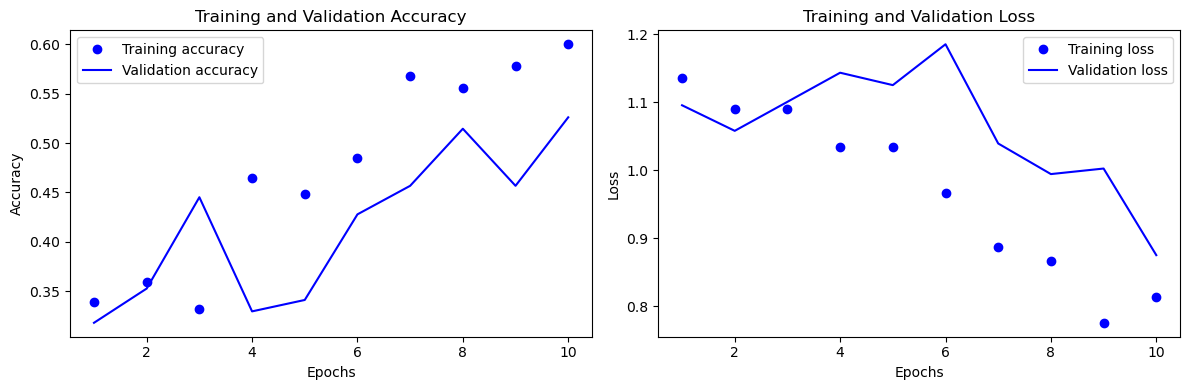

In [8]:
plot_training_history(history)

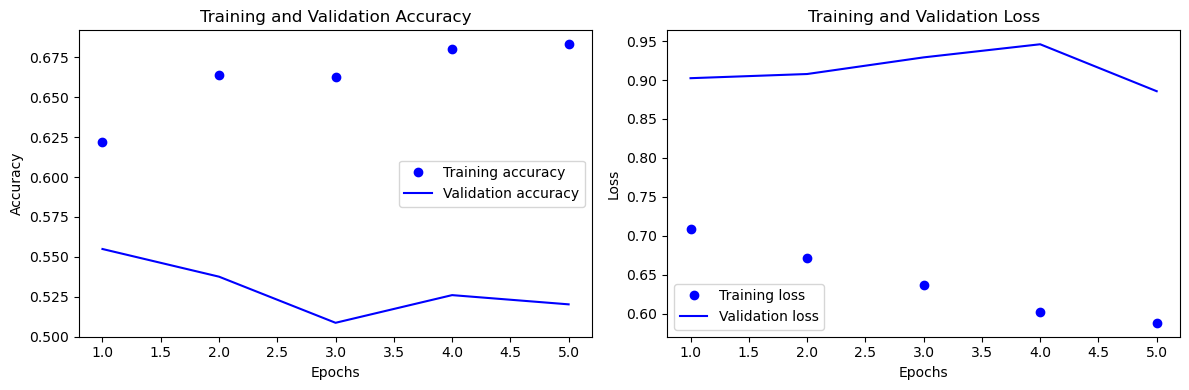

In [10]:
plot_training_history(history2)

In [42]:
test_model = keras.models.load_model("cnn.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 449ms/step - accuracy: 0.5330 - loss: 0.9065
Test accuracy: 0.526


## Data Augmentation

In [25]:
train_datagen = ImageDataGenerator(
    rescale=1./255,   # normalization
    shear_range=15,   # shearing [-15°, 15°]
    width_shift_range=0.15,  # translation [-15, 15]
    height_shift_range=0.15,
    rotation_range=25,  # rotation [-25°, 25°]
    zoom_range=0.2,     # zoom augmentation
    horizontal_flip=True,  # flip augmentation
)

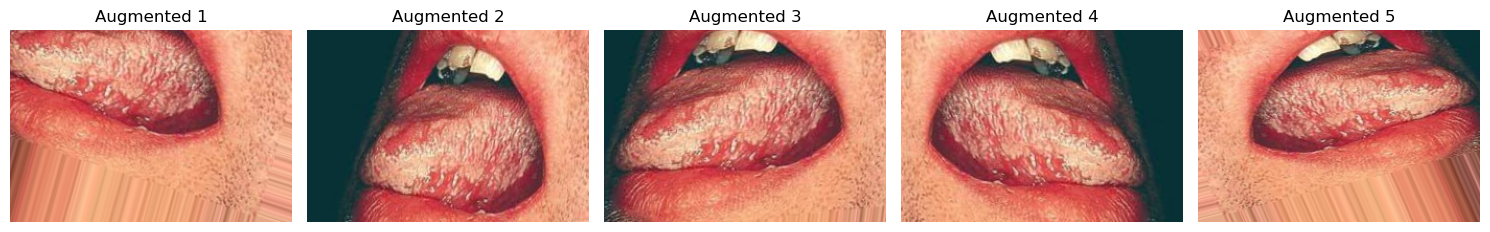

In [15]:
image_path = './oral_cancer_train_test_split/train/oral_cancer/oral_cancer.73.jpg'
image = load_img(image_path)  
image = img_to_array(image)   
image = np.expand_dims(image, axis=0)  

aug_iter = train_datagen.flow(image, batch_size=1)

fig, axes = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    batch = next(aug_iter)
    ax = axes[i]
    img = batch[0]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Augmented {i+1}')

plt.tight_layout()
plt.show()

In [26]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
        'oral_cancer_train_test_split/train/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

validation_data = test_datagen.flow_from_directory(
        'oral_cancer_train_test_split/test/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 685 images belonging to 3 classes.
Found 173 images belonging to 3 classes.


## Pre-trained Model

### ResNet101

In [7]:
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) 
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

resnet_model = Model(inputs=base_model.input, outputs=predictions)

resnet_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# resnet_model.summary()

In [29]:
# train resnet
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="resnet.keras", save_best_only=True, monitor="val_loss") ]

history = resnet_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=10,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

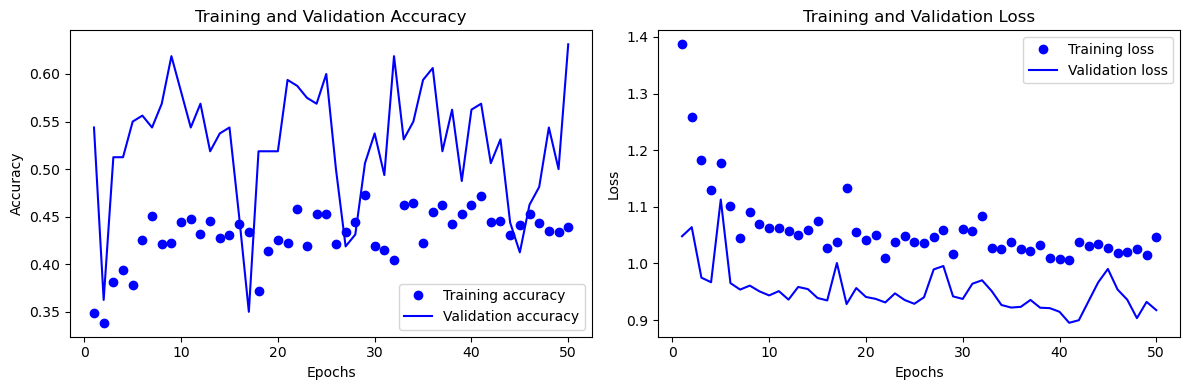

In [33]:
plot_training_history(history)

In [35]:
test_model = keras.models.load_model("resnet.keras")
test_loss, test_acc = test_model.evaluate(validation_data)
print(f"Test accuracy: {test_acc:.3f}")

6/6 [==============================] - 28s 4s/step - loss: 0.9024 - accuracy: 0.5318
Test accuracy: 0.532


### VGG16

In [24]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) 
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

vgg16_model = Model(inputs=base_model.input, outputs=predictions)

vgg16_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

vgg16_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,243,075 (58.15 MB)

 Trainable params: 528,387 (2.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [29]:
# train vgg16
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="vgg16.keras", save_best_only=True, monitor="val_loss") ]

history = vgg16_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=10,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

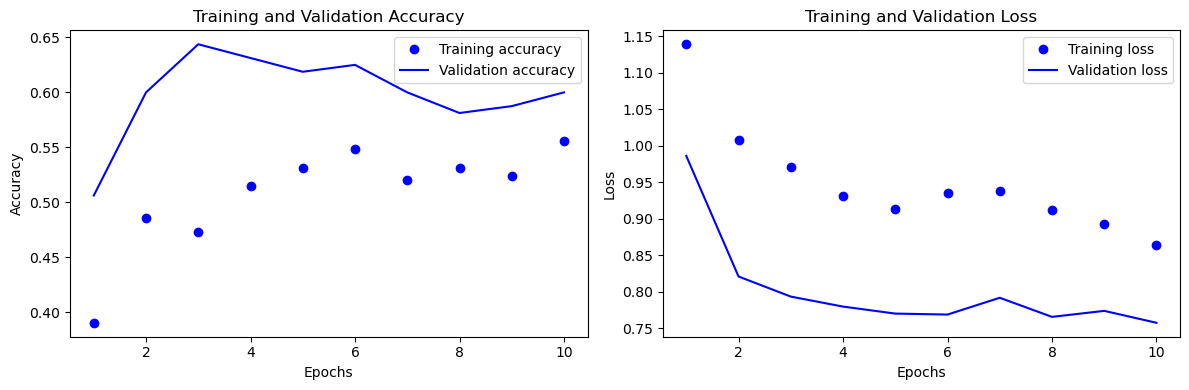

In [34]:
plot_training_history(history)

In [6]:
test_model = keras.models.load_model("vgg16.keras")
test_loss, test_acc = test_model.evaluate(validation_data)
print(f"Test accuracy: {test_acc:.3f}")

2024-09-19 15:00:42.175175: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-09-19 15:00:42.175226: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tech-desktop): /proc/driver/nvidia/version does not exist
2024-09-19 15:00:43.645180: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
2024-09-19 15:00:44.133718: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.


1/6 [====>.........................] - ETA: 47s - loss: 0.7134 - accuracy: 0.6562

2024-09-19 15:00:52.510485: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
2024-09-19 15:00:52.646732: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.


2/6 [=========>....................] - ETA: 33s - loss: 0.7058 - accuracy: 0.6250

2024-09-19 15:01:01.003504: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.


6/6 [==============================] - 47s 7s/step - loss: 0.7522 - accuracy: 0.6069
Test accuracy: 0.607


In [29]:
# more training
vgg16_model = keras.models.load_model("vgg16.keras")
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="vgg16.keras", save_best_only=True, monitor="val_loss") ]

history = vgg16_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=10,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

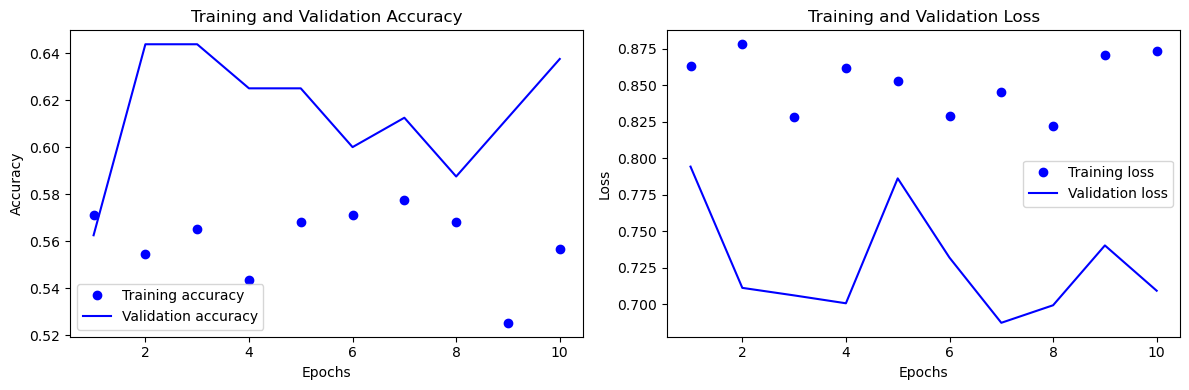

In [7]:
plot_training_history(history)

In [8]:
test_model = keras.models.load_model("vgg16.keras")
test_loss, test_acc = test_model.evaluate(validation_data)
print(f"Test accuracy: {test_acc:.3f}")

6/6 [==============================] - 45s 7s/step - loss: 0.6891 - accuracy: 0.6127
Test accuracy: 0.613


In [ ]:
# unfreeze top layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [29]:
# fine-tuning
vgg16_model = keras.models.load_model("vgg16.keras")
vgg16_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

callbacks = [ keras.callbacks.ModelCheckpoint( filepath="vgg16.keras", save_best_only=True, monitor="val_loss") ]

history = vgg16_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=20,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

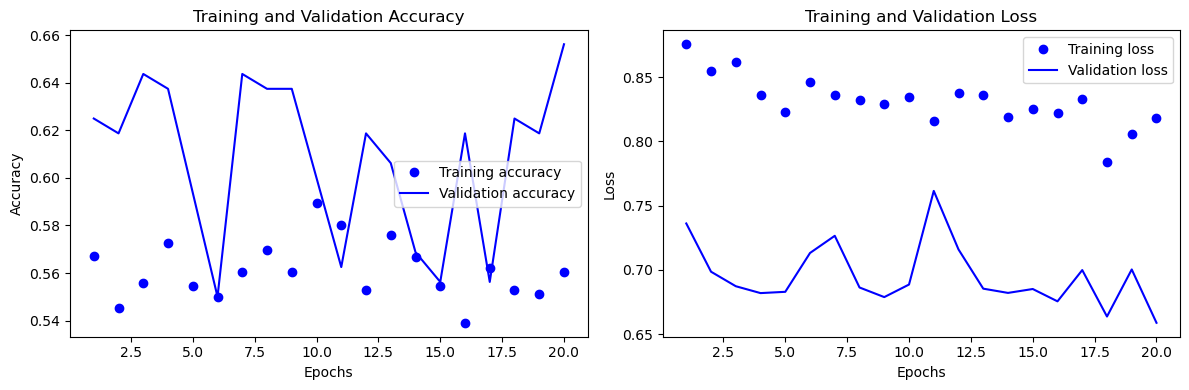

In [15]:
plot_training_history(history)

In [16]:
test_model = keras.models.load_model("vgg16.keras")
test_loss, test_acc = test_model.evaluate(validation_data)
print(f"Test accuracy: {test_acc:.3f}")

6/6 [==============================] - 46s 8s/step - loss: 0.6899 - accuracy: 0.6301
Test accuracy: 0.630


### InceptionV3

In [12]:
from keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) 
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

inceptionv3_model = Model(inputs=base_model.input, outputs=predictions)

inceptionv3_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# inceptionv3_model.summary()

In [ ]:
# train inceptionv3
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="inceptionv3.keras", save_best_only=True, monitor="val_loss") ]

history = inceptionv3_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=10,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

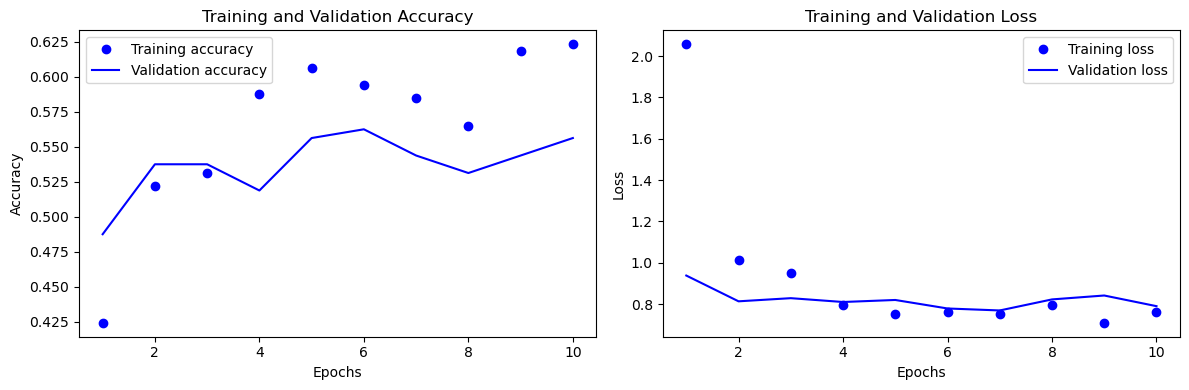

In [18]:
plot_training_history(history)

In [19]:
test_model = keras.models.load_model("inceptionv3.keras")
test_loss, test_acc = test_model.evaluate(validation_data)
print(f"Test accuracy: {test_acc:.3f}")

6/6 [==============================] - 11s 2s/step - loss: 0.7677 - accuracy: 0.5376
Test accuracy: 0.538


In [ ]:
# train more
inceptionv3_model = keras.models.load_model("inceptionv3.keras")
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="inceptionv3.keras", save_best_only=True, monitor="val_loss") ]

history = inceptionv3_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=10,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

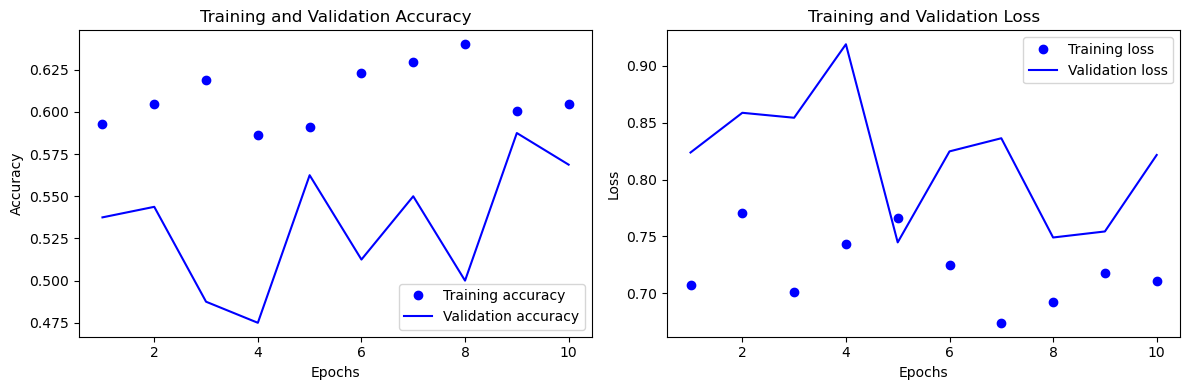

In [21]:
plot_training_history(history)

In [22]:
test_model = keras.models.load_model("inceptionv3.keras")
test_loss, test_acc = test_model.evaluate(validation_data)
print(f"Test accuracy: {test_acc:.3f}")

6/6 [==============================] - 10s 2s/step - loss: 0.7577 - accuracy: 0.5607
Test accuracy: 0.561


In [ ]:
# train more
inceptionv3_model = keras.models.load_model("inceptionv3.keras")
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="inceptionv3.keras", save_best_only=True, monitor="val_loss") ]

history = inceptionv3_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=20,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

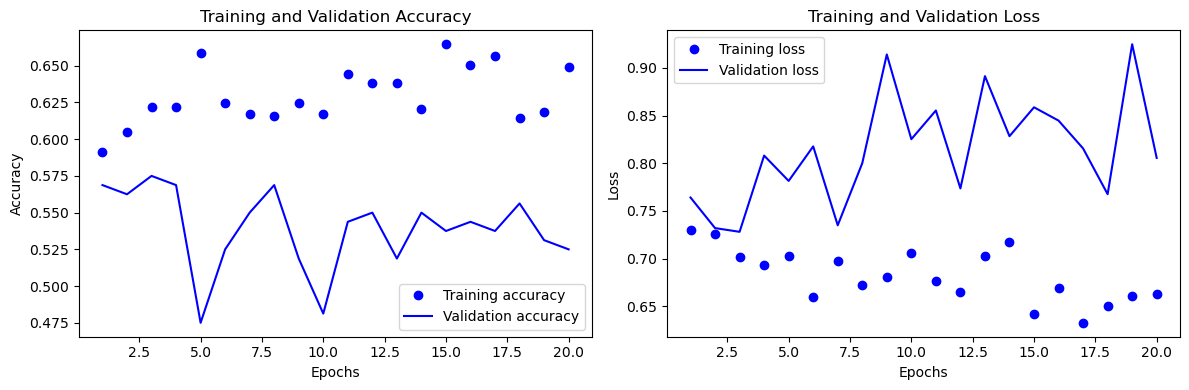

In [6]:
plot_training_history(history)

In [22]:
test_model = keras.models.load_model("inceptionv3.keras")
test_loss, test_acc = test_model.evaluate(validation_data)
print(f"Test accuracy: {test_acc:.3f}")

6/6 [==============================] - 10s 2s/step - loss: 0.7577 - accuracy: 0.5607
Test accuracy: 0.561


In [ ]:
# fine-tuning
# freeze the first 249 layers and unfreeze the rest
for layer in base_model.layers[:310]:
    layer.trainable = False
for layer in base_model.layers[310:]:
    layer.trainable = True
    
inceptionv3_model = keras.models.load_model("inceptionv3.keras")
inceptionv3_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

callbacks = [ keras.callbacks.ModelCheckpoint( filepath="inceptionv3.keras", save_best_only=True, monitor="val_loss") ]

history = inceptionv3_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=10,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

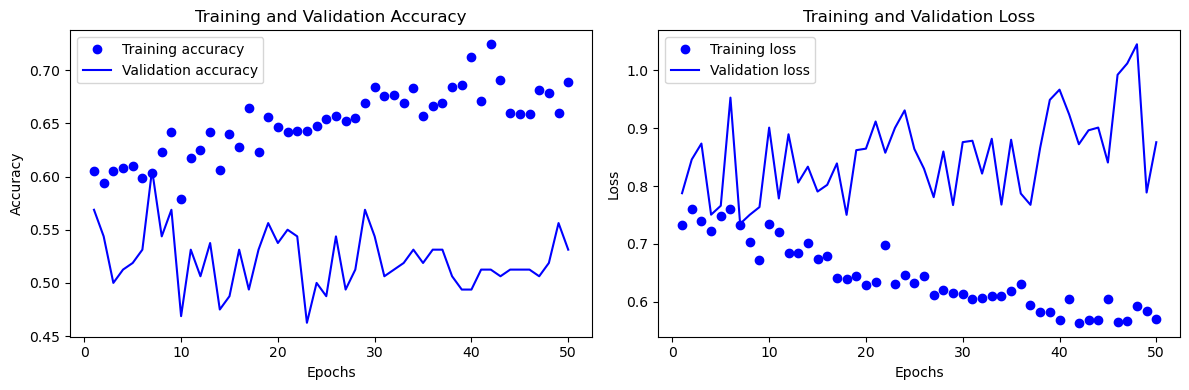

In [8]:
plot_training_history(history)

In [9]:
test_model = keras.models.load_model("inceptionv3.keras")
test_loss, test_acc = test_model.evaluate(validation_data)
print(f"Test accuracy: {test_acc:.3f}")

6/6 [==============================] - 13s 1s/step - loss: 0.7495 - accuracy: 0.5954
Test accuracy: 0.595


### DenseNet121

In [10]:
from tensorflow.keras.applications import DenseNet121

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dropout(0.5)(x)  
x = Dense(1024, activation='relu')(x)  
predictions = Dense(3, activation='softmax')(x)

densenet_model = Model(inputs=base_model.input, outputs=predictions)

densenet_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="densenet.keras", save_best_only=True, monitor="val_loss") ]

history = densenet_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

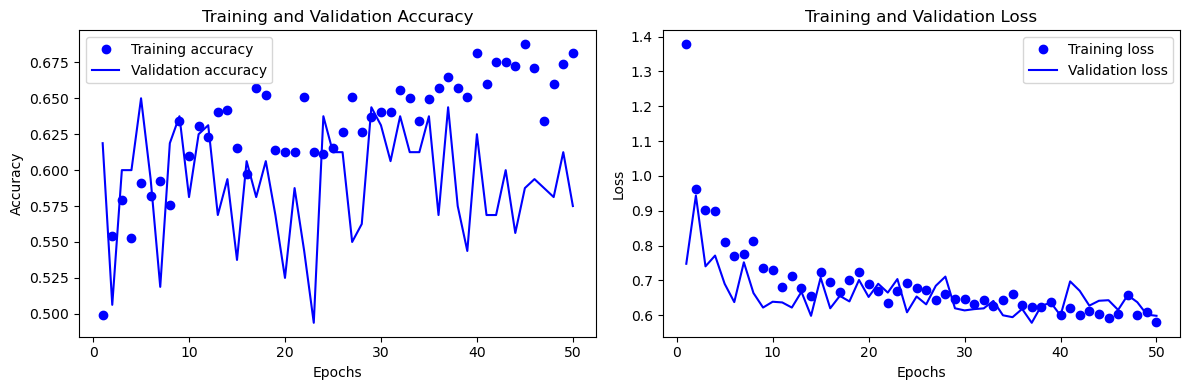

In [22]:
plot_training_history(history)

In [23]:
test_model = keras.models.load_model("densenet.keras")
test_loss, test_acc = test_model.evaluate(validation_data)
print(f"Test accuracy: {test_acc:.3f}")

6/6 [==============================] - 15s 2s/step - loss: 0.5799 - accuracy: 0.6474
Test accuracy: 0.647


## Cross Validation

In [46]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from tqdm import tqdm

densenet_model = keras.models.load_model('densenet.keras')
vgg16_model = keras.models.load_model('vgg16.keras')
resnet_model = keras.models.load_model('resnet.keras')

data = test_datagen.flow_from_directory(
    'oral_cancer_train_test_split/train/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

class_map = {v: k for k, v in data.class_indices.items()}
print("Class Map:", class_map)

X = data.filepaths
y_train_str = [class_map[label] for label in y_train]
y_val_str = [class_map[label] for label in y_val]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {
    'densenet121': {'accuracy': [], 'precision': [], 'recall': [], 'f1': []},
    'vgg16': {'accuracy': [], 'precision': [], 'recall': [], 'f1': []},
    'resnet': {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
}

for train_idx, val_idx in tqdm(skf.split(X, y)):
    X_train, X_val = np.array(X)[train_idx], np.array(X)[val_idx]
    y_train, y_val = np.array(y)[train_idx], np.array(y)[val_idx]
    
    val_gen = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': X_val, 'class': y_val_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )
    
    val_predictions = densenet_model.predict(val_gen)
    val_pred_classes = np.argmax(val_predictions, axis=1)
    
    val_accuracy = accuracy_score(y_val, val_pred_classes)
    val_precision = precision_score(y_val, val_pred_classes, average='macro')
    val_recall = recall_score(y_val, val_pred_classes, average='macro')
    val_f1 = f1_score(y_val, val_pred_classes, average='macro')
    
    results['densenet121']['accuracy'].append(val_accuracy)
    results['densenet121']['precision'].append(val_precision)
    results['densenet121']['recall'].append(val_recall)
    results['densenet121']['f1'].append(val_f1)
    
    val_predictions = vgg16_model.predict(val_gen)
    val_pred_classes = np.argmax(val_predictions, axis=1)
    
    val_accuracy = accuracy_score(y_val, val_pred_classes)
    val_precision = precision_score(y_val, val_pred_classes, average='macro')
    val_recall = recall_score(y_val, val_pred_classes, average='macro')
    val_f1 = f1_score(y_val, val_pred_classes, average='macro')
    
    results['vgg16']['accuracy'].append(val_accuracy)
    results['vgg16']['precision'].append(val_precision)
    results['vgg16']['recall'].append(val_recall)
    results['vgg16']['f1'].append(val_f1)
    
    val_predictions = resnet_model.predict(val_gen)
    val_pred_classes = np.argmax(val_predictions, axis=1)
    
    val_accuracy = accuracy_score(y_val, val_pred_classes)
    val_precision = precision_score(y_val, val_pred_classes, average='macro')
    val_recall = recall_score(y_val, val_pred_classes, average='macro')
    val_f1 = f1_score(y_val, val_pred_classes, average='macro')
    
    results['resnet']['accuracy'].append(val_accuracy)
    results['resnet']['precision'].append(val_precision)
    results['resnet']['recall'].append(val_recall)
    results['resnet']['f1'].append(val_f1)
    
for model_name in results:
    print(f"Results for {model_name}:")
    print(f"  Average Accuracy: {np.mean(results[model_name]['accuracy']):.4f}")
    print(f"  Average Precision: {np.mean(results[model_name]['precision']):.4f}")
    print(f"  Average Recall: {np.mean(results[model_name]['recall']):.4f}")
    print(f"  Average F1 Score: {np.mean(results[model_name]['f1']):.4f}")

Found 685 images belonging to 3 classes.
Class Map: {0: 'normal', 1: 'oral_cancer', 2: 'pre_cancer'}


0it [00:00, ?it/s]

Found 137 validated image filenames belonging to 3 classes.
5/5 [==============================] - 38s 7s/step


/home/research/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 [==============================] - 24s 4s/step


1it [01:18, 78.62s/it]

Found 137 validated image filenames belonging to 3 classes.
5/5 [==============================] - 42s 8s/step


/home/research/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 [==============================] - 23s 4s/step


2it [02:37, 78.61s/it]

Found 137 validated image filenames belonging to 3 classes.
5/5 [==============================] - 41s 8s/step


/home/research/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 [==============================] - 22s 4s/step


3it [04:52, 104.47s/it]

Found 137 validated image filenames belonging to 3 classes.
5/5 [==============================] - 44s 9s/step


/home/research/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 [==============================] - 23s 4s/step


4it [06:31, 102.29s/it]

Found 137 validated image filenames belonging to 3 classes.
5/5 [==============================] - 46s 9s/step


/home/research/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 [==============================] - 23s 4s/step


5it [07:53, 94.71s/it] 

Results for densenet121:
  Average Accuracy: 0.7372
  Average Precision: 0.7643
  Average Recall: 0.7383
  Average F1 Score: 0.7244
Results for vgg16:
  Average Accuracy: 0.6044
  Average Precision: 0.4455
  Average Recall: 0.5980
  Average F1 Score: 0.4989
Results for resnet:
  Average Accuracy: 0.4964
  Average Precision: 0.5046
  Average Recall: 0.4874
  Average F1 Score: 0.4192


## Evaluation

6/6 [==============================] - 15s 2s/step - loss: 0.5799 - accuracy: 0.6474
Test Accuracy: 0.6474
Test Loss: 0.5799
6/6 [==============================] - 15s 2s/step
              precision    recall  f1-score   support

      normal       0.33      0.32      0.33        53
 oral_cancer       0.44      0.12      0.19        57
  pre_cancer       0.40      0.67      0.50        63

    accuracy                           0.38       173
   macro avg       0.39      0.37      0.34       173
weighted avg       0.39      0.38      0.34       173



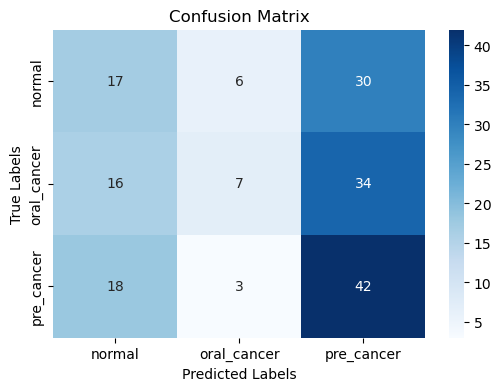

In [54]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

best_model = keras.models.load_model('densenet.keras')

test_loss, test_accuracy = best_model.evaluate(validation_data)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred = best_model.predict(validation_data)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = validation_data.classes

class_labels = list(validation_data.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

## Prediction

1/1 [==============================] - 0s 103ms/step


Image: normal.254.jpeg - True Class: normal, Predicted Class: normal
Image: normal.216.jpeg - True Class: normal, Predicted Class: normal
Image: normal.227.jpeg - True Class: normal, Predicted Class: normal
Image: normal.245.jpeg - True Class: normal, Predicted Class: normal
Image: normal.247.jpeg - True Class: normal, Predicted Class: normal
Image: oral_cancer.273.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.256.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.227.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.246.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.274.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: pre_cancer.276.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.263.jpg - True Class: pre_cancer, Predicted Class: oral_cancer
Image: pre_cancer.310.jpg - 

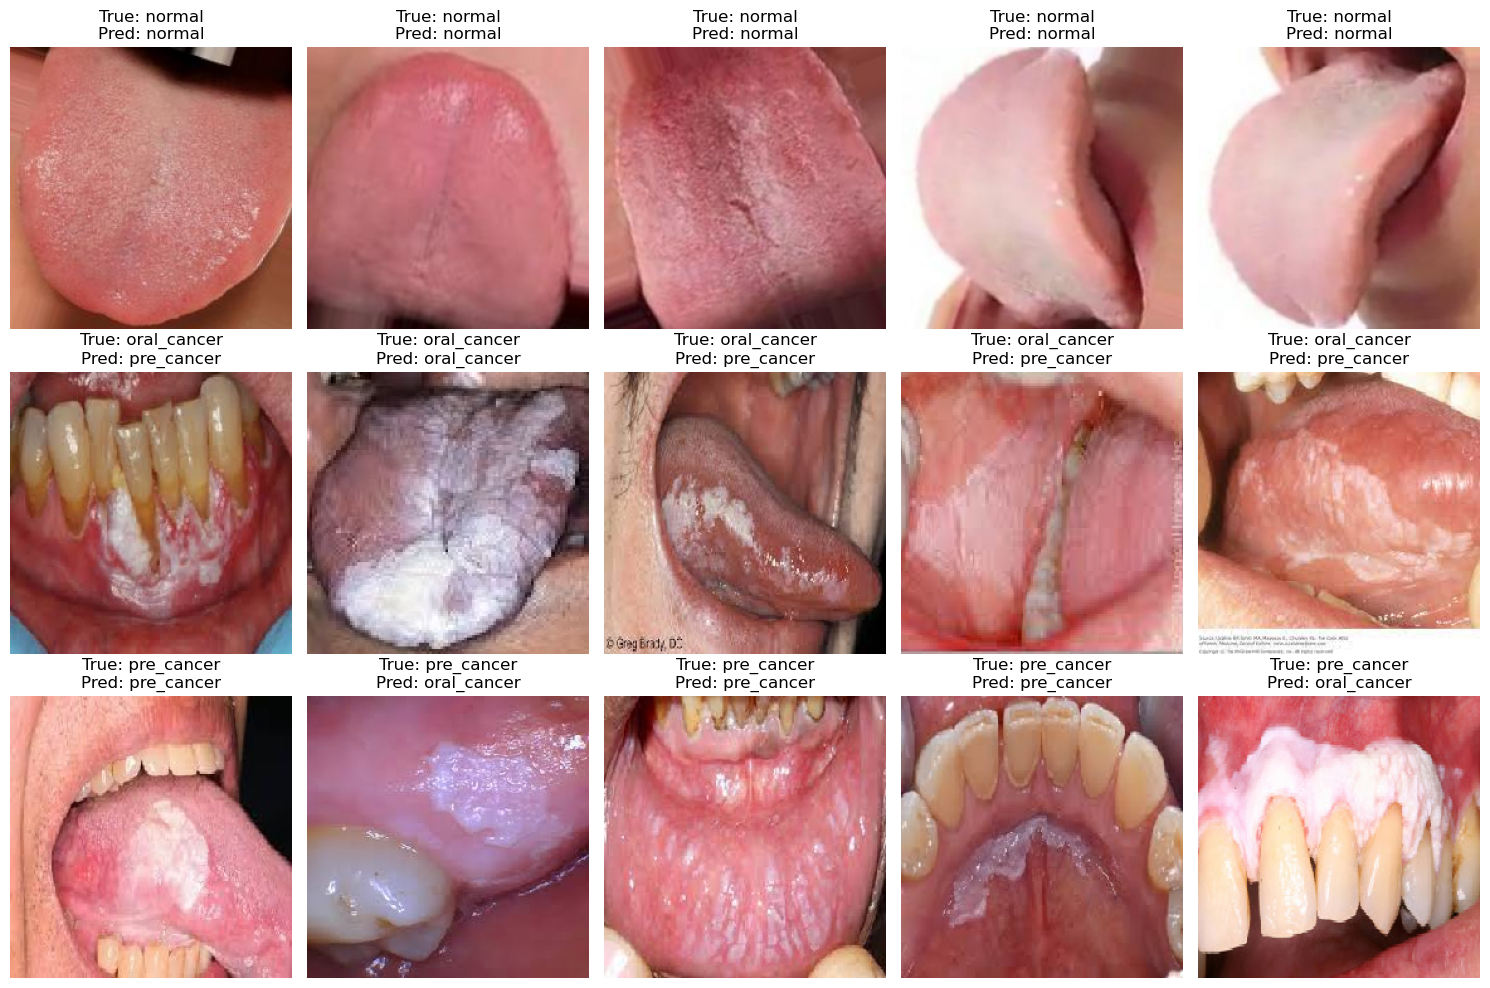

In [49]:
from tensorflow.keras.preprocessing import image
import random

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    return np.expand_dims(img_array, axis=0)

def load_images_from_class(class_dir, class_label, num_images=5):
    images = []
    img_files = random.sample(os.listdir(class_dir), num_images)
    for img_file in img_files:
        img_path = os.path.join(class_dir, img_file)
        img_array = load_and_preprocess_image(img_path)
        images.append((img_path, img_array, class_label))
    return images

root_dir = './oral_cancer_train_test_split/test'
class_names = ['normal', 'oral_cancer', 'pre_cancer']

all_images = []
for class_name in class_names:
    class_dir = os.path.join(root_dir, class_name)
    all_images.extend(load_images_from_class(class_dir, class_name))
    
best_model = keras.models.load_model('densenet.keras')
class_map = {0: 'normal', 1: 'oral_cancer', 2: 'pre_cancer'}

predictions = []
for img_path, img_array, true_class in all_images:
    pred = best_model.predict(img_array)
    pred_class_idx = np.argmax(pred, axis=1)[0]
    
    predictions.append((img_path, true_class, class_map[pred_class_idx]))

print('\n')
for img_path, true_class, pred_class in predictions:
    print(f"Image: {os.path.basename(img_path)} - True Class: {true_class}, Predicted Class: {pred_class}")
    
def display_images_with_predictions(images, predictions, class_map):
    plt.figure(figsize=(15, 10))
    
    for i, (img_path, true_class, pred_class) in enumerate(predictions):
        img = image.load_img(img_path, target_size=(224, 224))  
        
        plt.subplot(3, 5, i + 1) 
        plt.imshow(img)
        plt.title(f'True: {true_class}\nPred: {pred_class}') 
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

display_images_with_predictions(all_images, predictions, class_map)